In [ ]:
import pandas as pd
df = pd.read_parquet('fhvhv_tripdata_2025-01.parquet')


In [2]:
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee
0,HV0003,B03404,B03404,2025-01-01 00:28:07,2025-01-01 00:31:17,2025-01-01 00:33:25,2025-01-01 00:54:24,148,211,1.320,...,2.75,0.0,0.0,15.71,N,N,N,N,N,0.0
1,HV0005,B03406,None,2025-01-01 00:18:33,NaT,2025-01-01 00:29:49,2025-01-01 00:41:52,127,244,3.313,...,0.00,0.0,0.0,23.57,N,N,N,N,N,0.0
2,HV0003,B03404,B03404,2025-01-01 00:28:22,2025-01-01 00:31:52,2025-01-01 00:32:39,2025-01-01 01:20:33,132,181,13.430,...,0.00,2.5,0.0,47.75,N,N,N,N,N,0.0
3,HV0003,B03404,B03404,2025-01-01 00:27:13,2025-01-01 00:33:58,2025-01-01 00:34:55,2025-01-01 00:39:19,76,76,0.820,...,0.00,0.0,0.0,12.20,N,N,N,N,N,0.0
4,HV0003,B03404,B03404,2025-01-01 00:33:29,2025-01-01 00:45:46,2025-01-01 00:46:19,2025-01-01 00:53:56,76,76,1.610,...,0.00,0.0,0.0,17.67,N,N,N,N,N,0.0


In [38]:
df.shape

(20405666, 25)

In [39]:
df_sample = df.sample(n=100000, random_state=42).reset_index(drop=True)


In [40]:
df_sample.shape

(100000, 25)

In [41]:
df_sample = df[
    (df['pickup_datetime'] >= '2025-01-01') &
    (df['pickup_datetime'] < '2025-01-08')
].copy()


In [42]:
# Drop rows with missing critical values
df = df.dropna(subset=['pickup_datetime', 'dropoff_datetime', 'trip_miles'])

# Ensure datetime is in correct format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Trip duration in minutes
df['trip_duration_min'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
df = df[df['trip_duration_min'] > 0]


In [43]:
# Ride flags
df['is_shared'] = df['shared_match_flag'].map({'Y': 1, 'N': 0})

# Time features
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6])
df['is_night_ride'] = df['hour'].apply(lambda x: 1 if x >= 22 or x < 5 else 0)
df['is_commute_hour'] = df['hour'].apply(lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 18) else 0)


One row = One ride taken by a rider. original dataset has millions of individual trips — but it doesn’t tell us which trips belong to the same person.
Trip #1 → rider R0012

Trip #2 → rider R0048

Trip #3 → rider R0012 again (same person!)

Now you can group all trips by rider and say:

“Show me how often R0012 rides at night, or uses shared rides, or rides on weekends.”

In [44]:
import numpy as np
df['rider_id'] = np.random.choice([f'R{str(i).zfill(4)}' for i in range(1000)], size=len(df))

In [45]:
rider_features = df.groupby('rider_id').agg({
    'trip_miles': ['mean', 'std'],
    'trip_duration_min': ['mean'],
    'is_shared': 'mean',
    'is_weekend': 'mean',
    'is_night_ride': 'mean',
    'is_commute_hour': 'mean',
    'pickup_datetime': 'count'
})

# Clean column names
rider_features.columns = [
    'avg_trip_miles', 'std_trip_miles',
    'avg_trip_duration',
    'pct_shared_rides',
    'pct_weekend_rides',
    'pct_night_rides',
    'pct_commute_hour_rides',
    'total_trips'
]

rider_features = rider_features.fillna(0)
rider_features.head()


,avg_trip_miles,std_trip_miles,avg_trip_duration,pct_shared_rides,pct_weekend_rides,pct_night_rides,pct_commute_hour_rides,total_trips
rider_id,,,,,,,,
R0000,4.850217,5.639765,18.222591,0.022727,0.276134,0.198705,0.312293,20548
R0001,4.860243,5.795075,18.195782,0.022244,0.268492,0.194378,0.325251,20455
R0002,4.885407,5.729985,18.166020,0.022692,0.268444,0.198137,0.317297,20183
R0003,4.798976,5.675557,18.083328,0.021711,0.269639,0.193700,0.325563,20635
R0004,4.792220,5.629388,18.088747,0.022768,0.266869,0.192212,0.319343,20467


In [46]:
from sklearn.preprocessing import StandardScaler

# Create a copy to preserve original
X = rider_features.copy()

# Initialize scaler and transform
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [47]:
from sklearn.preprocessing import StandardScaler

X = rider_features.drop(columns=['total_trips'])  # drop total_trips if you want less bias from heavy users
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [48]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
rider_features['cluster'] = kmeans.fit_predict(X_scaled)


In [49]:
cluster_summary = rider_features.groupby('cluster').mean()
import pandas as pd
pd.set_option('display.max_columns', None)  # to view all columns
cluster_summary


,avg_trip_miles,std_trip_miles,avg_trip_duration,pct_shared_rides,pct_weekend_rides,pct_night_rides,pct_commute_hour_rides,total_trips
cluster,,,,,,,,
0,4.802130,5.599956,18.123124,0.022757,0.269944,0.197099,0.319184,20395.604167
1,4.907503,5.885943,18.334044,0.023606,0.270130,0.196202,0.319877,20398.169935
2,4.855281,5.738820,18.241489,0.022253,0.270573,0.194469,0.321917,20402.612745
3,4.858356,5.715811,18.231938,0.023319,0.271515,0.198629,0.317284,20419.762646
4,4.838273,5.663141,18.219878,0.023887,0.268022,0.194747,0.322783,20406.051546


In [50]:
cluster_labels = {
    0: 'Daily Commuter',
    1: 'Night Owl',
    2: 'Tourist',
    3: 'Pool-only Rider',
    4: 'Occasional Rider'
}


In [51]:
rider_features['persona'] = rider_features['cluster'].map(cluster_labels)


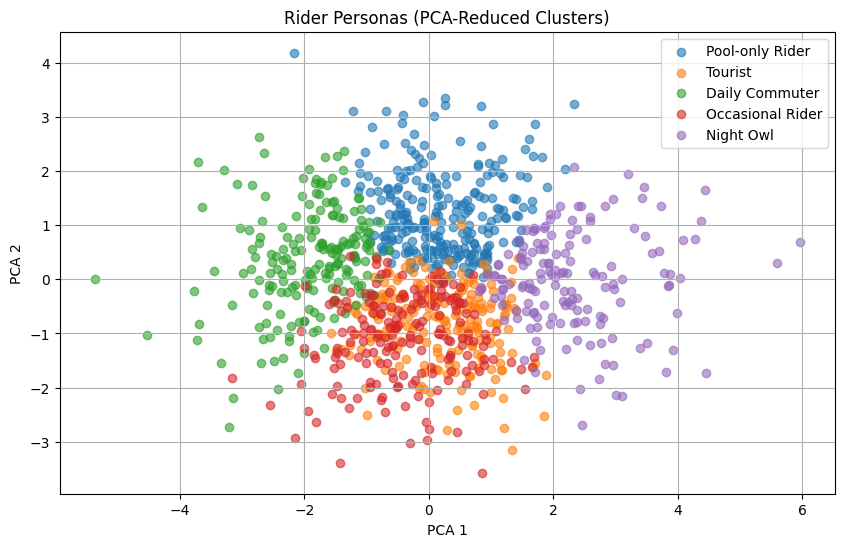

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce scaled features to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add to DataFrame
rider_features['pca1'] = X_pca[:, 0]
rider_features['pca2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(10, 6))
for label in rider_features['persona'].unique():
    subset = rider_features[rider_features['persona'] == label]
    plt.scatter(subset['pca1'], subset['pca2'], label=label, alpha=0.6)

plt.title("Rider Personas (PCA-Reduced Clusters)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Inputs and labels
X_model = rider_features.drop(['cluster', 'persona', 'pca1', 'pca2'], axis=1)
y_model = rider_features['persona']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


                  precision    recall  f1-score   support

  Daily Commuter       0.91      0.91      0.91        43
       Night Owl       0.92      0.92      0.92        25
Occasional Rider       0.89      0.75      0.81        44
 Pool-only Rider       0.83      0.98      0.90        50
         Tourist       0.89      0.84      0.86        38

        accuracy                           0.88       200
       macro avg       0.89      0.88      0.88       200
    weighted avg       0.88      0.88      0.88       200



In [54]:
rider_features.groupby('cluster').mean()


,avg_trip_miles,std_trip_miles,avg_trip_duration,pct_shared_rides,pct_weekend_rides,pct_night_rides,pct_commute_hour_rides,total_trips,pca1,pca2
cluster,,,,,,,,,,
0,4.802130,5.599956,18.123124,0.022757,0.269944,0.197099,0.319184,20395.604167,-1.934002,0.353297
1,4.907503,5.885943,18.334044,0.023606,0.270130,0.196202,0.319877,20398.169935,2.321018,-0.027362
2,4.855281,5.738820,18.241489,0.022253,0.270573,0.194469,0.321917,20402.612745,0.178899,-0.819735
3,4.858356,5.715811,18.231938,0.023319,0.271515,0.198629,0.317284,20419.762646,0.212902,1.229610
4,4.838273,5.663141,18.219878,0.023887,0.268022,0.194747,0.322783,20406.051546,-0.386591,-1.095002


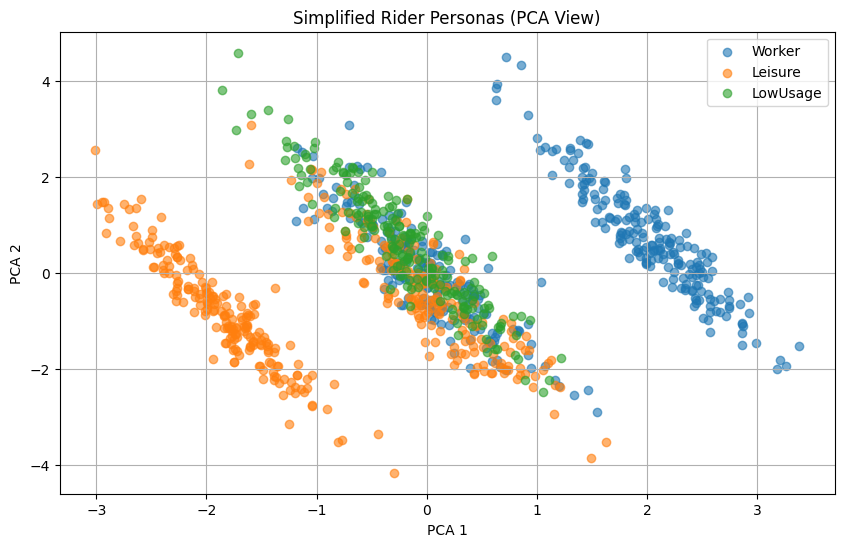

              precision    recall  f1-score   support

     Leisure       1.00      1.00      1.00        86
    LowUsage       1.00      1.00      1.00        44
      Worker       1.00      1.00      1.00        70

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [72]:
# (Simplified Personas) - Synthetic Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#  Load dataset
dfs = pd.read_csv("persona_rider_features_unlabeled.csv")


X = dfs.drop(columns=["rider_id"])

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Cluster with KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
dfs['cluster'] = kmeans.fit_predict(X_scaled)

# Assign original persona labels (manually interpreted)
original_labels = {
    0: 'Mixed User',
    1: 'Night Owl',
    2: 'Tourist',
    3: 'Daily Commuter',
    4: 'Occasional Rider'
}
dfs['persona'] = dfs['cluster'].map(original_labels)

# Simplify to 3 broad categories
simplified_map = {
    'Daily Commuter': 'Worker',
    'Mixed User': 'Worker',
    'Night Owl': 'Leisure',
    'Tourist': 'Leisure',
    'Occasional Rider': 'LowUsage'
}
dfs['simple_persona'] = dfs['persona'].map(simplified_map)

#PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
dfs['pca1'], dfs['pca2'] = X_pca[:, 0], X_pca[:, 1]

#Visualize the simplified personas
plt.figure(figsize=(10, 6))
for label in dfs['simple_persona'].unique():
    subset = dfs[dfs['simple_persona'] == label]
    plt.scatter(subset['pca1'], subset['pca2'], label=label, alpha=0.6)
plt.title("Simplified Rider Personas (PCA View)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

#Prepare for classification
X_model = dfs.drop(columns=['rider_id', 'cluster', 'persona', 'simple_persona', 'pca1', 'pca2'])
y_model = dfs['simple_persona']

#Train-test split and classifier
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
